# Modeling with a Regressive Neural Network

##### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# make numpy printous easier to read
np.set_printoptions(precision=3, suppress=True)

In [4]:
df = pd.read_csv('./data/working_data.csv')

y = df['pcpv']
X = df[['ord_cdr', 'unemploy_rate', 'arf_cdr', 'prcnt_poverty', 'pct_medicare', 
        'pct_duals', 'hpsa_part', 'nonmetro', 'op_pc', 'per_cap_medicare_cost', 
        'pdmp_req_check', 'spec_55t64_pc', 'spec_65t74_pc', 'dentists_65plus_pc', 
        'med_househld_income', 'hpsa_whole', 'prcnt_25up_college', 'pct_men', 'rural', 'per_cap_income', 
        'pct_hisp', 'np_rx']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


### Tensorflow Regression

In [5]:
# adds feature normalization to the model
# create the layer
normalizer = tf.keras.layers.Normalization(axis=-1)

In [6]:
# fit the preprossing layer to the data
normalizer.adapt(X_train)

In [7]:
# calculate the mean and variance and store for later
print(normalizer.mean.numpy())

[[   32.89      7.108     0.992    16.326    19.055     4.093     0.412
      0.453     2.53   8369.116     0.02      8.798     3.186     4.747
  44071.344     0.394    20.175    49.81      0.178 34638.105     8.019
      0.143]]


In [8]:
# when the layer is called, it returns the input data 
# with each feature independently normalized
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   30.49     6.3      0.65     5.7     15.47     1.49     1.       0.
      2.1   8483.36     0.      16.6      4.74     8.13 73402.       0.
     38.      49.84     0.   52472.       2.08     1.  ]]

Normalized: [[-0.11 -0.27 -1.34 -1.69 -0.77 -1.03  1.19 -0.91 -0.13  0.08 -0.14  0.62
   0.28  0.62  2.58 -0.81  1.97  0.01 -0.47  1.8  -0.47  2.45]]


In [9]:
# for MLR create a two-step Keras Sequential model with
# the first layer being the 'normalizer'
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [10]:
# predict with a batch of inputs returns a 1 unit output 
# for each example
linear_model.predict(X_train[:10])

array([[ 1.371],
       [ 0.264],
       [ 0.6  ],
       [ 0.618],
       [ 1.448],
       [-0.955],
       [-1.441],
       [-0.198],
       [ 0.9  ],
       [-2.126]], dtype=float32)

In [11]:
# can check the kernal weights (m in y=mx+b)
# should have the shape of (n-features, 1)
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(22, 1) dtype=float32, numpy=
array([[ 0.147],
       [-0.038],
       [-0.304],
       [-0.459],
       [-0.024],
       [-0.328],
       [-0.151],
       [ 0.249],
       [-0.478],
       [-0.068],
       [ 0.068],
       [ 0.303],
       [ 0.035],
       [ 0.177],
       [ 0.157],
       [-0.028],
       [-0.391],
       [ 0.349],
       [-0.124],
       [ 0.055],
       [ 0.396],
       [ 0.106]], dtype=float32)>

In [12]:
# configure the model
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [13]:
# fit for 100 epochs
history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [50]:
# function to plot the loss history
def plot_loss(history):
    plt.figure(figsize=(15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([5, 16])
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Error [PCPV]', fontsize=13)
    plt.legend(prop={'size':15})
    plt.grid(True)

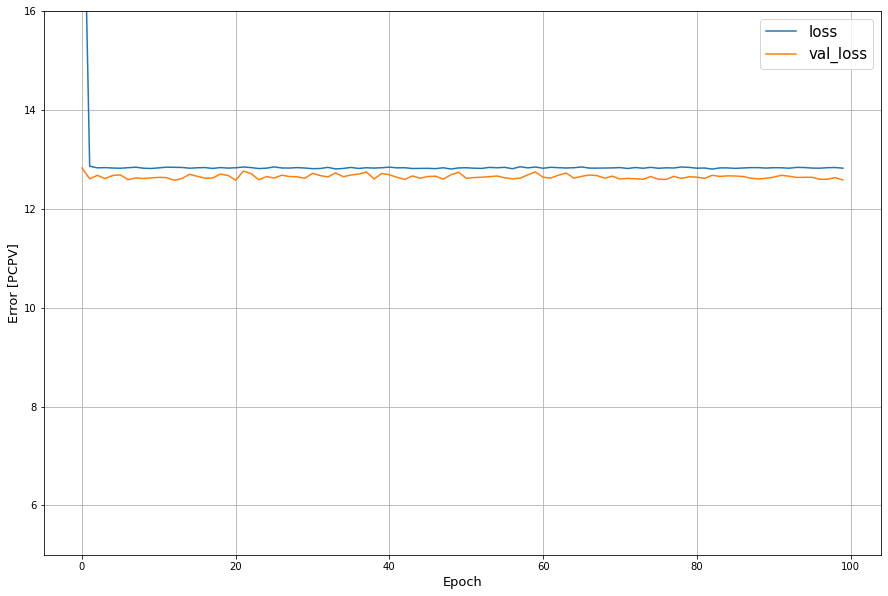

In [51]:
# loss history for a multi linear regression model
plot_loss(history)

In [16]:
# creating and adding to a 'test_results' dictionary
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    X_test, y_test, verbose=0)

#### Deep Neural Network Regression

In [17]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [18]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 22)               45        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                1472      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,742
Trainable params: 5,697
Non-trainable params: 45
_________________________________________________________________


In [19]:
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

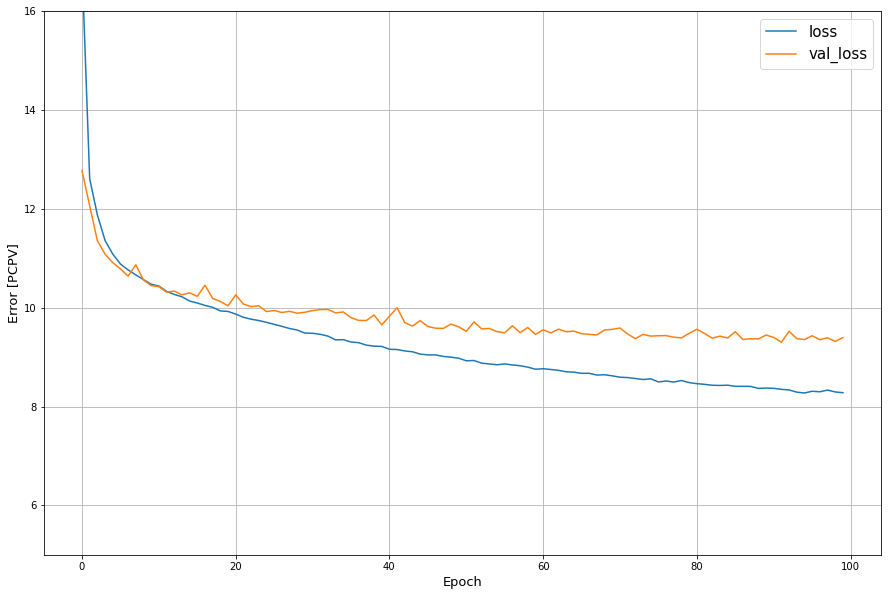

In [52]:
# loss history for a deep neural network model
plot_loss(dnn_history)

In [21]:
# saving the test results to the dictionary
test_results['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

In [22]:
# comparing the two models metrics 
pd.DataFrame(test_results, index=['Mean absolute error [PCPV]']).T

,Mean absolute error [PCPV]
linear_model,12.713649
dnn_model,9.496708


#### Performance

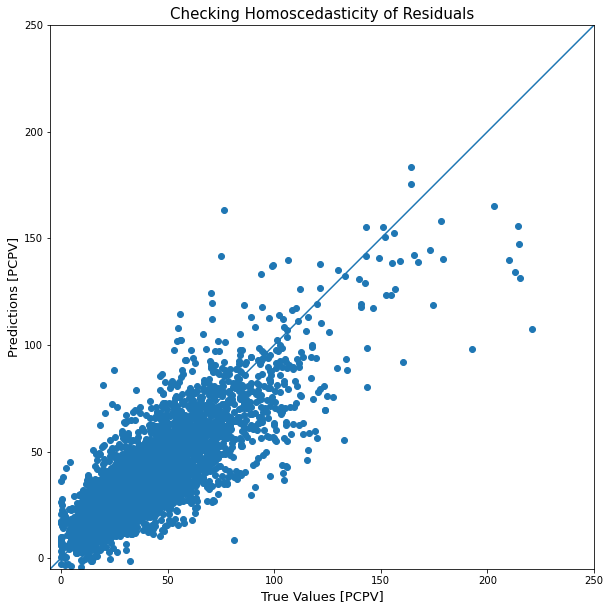

In [39]:
# checking the residuals of our predictions

test_predictions = dnn_model.predict(X_test).flatten()
plt.figure(figsize=(15,10))
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [PCPV]', fontsize=13)
plt.ylabel('Predictions [PCPV]', fontsize=13)
plt.title('Checking Homoscedasticity of Residuals', fontsize=15)

lims = [-5, 250]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Text(0.5, 1.0, 'Residual Distribution')

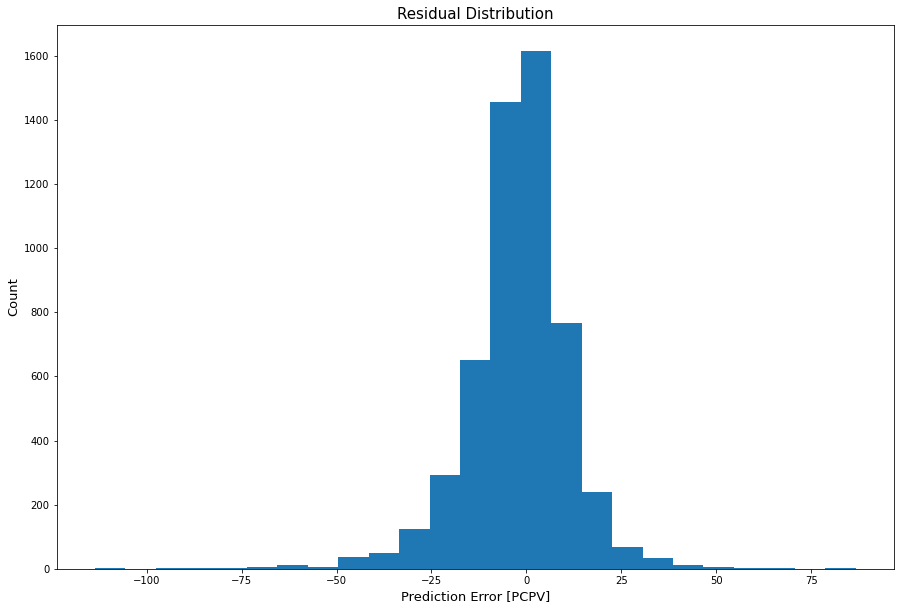

In [40]:
# checking the residual distribution

error = test_predictions - y_test
plt.figure(figsize=(15,10))
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [PCPV]', fontsize=13)
_ = plt.ylabel('Count', fontsize=13)
plt.title('Residual Distribution', fontsize=15)

In [25]:
y_true = y_test
y_true.describe

<bound method NDFrame.describe of 5377     17.445221
16213    19.888668
19180    39.711803
16139    14.909512
7427     47.120887
           ...    
2202     21.201779
26708    94.435015
10045    27.596105
22560     7.224993
16827    49.916679
Name: pcpv, Length: 5391, dtype: float64>

In [26]:
y_pred = dnn_model.predict(X_test).flatten().astype('float64')
y_pred

array([20.059, 24.072, 31.875, ..., 32.16 ,  6.37 , 35.742])

In [28]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_true, y_pred)

In [29]:
result = metric.result()
result.numpy()

0.6791058

#### Conclusion

- Running the data through a neural network that simulated the previous linear regression model resulted in a similar, if not exact Mean Absolute Error, showing that the NN model is evaluating the data correctly.